In [1]:
%cd /home/yokoyama/ahar
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

sys.path.append(".")
from modules.individual import IndividualActivityRecognition, IndividualDataFormat, IndividualDataHandler
from modules.utils.logger import logger
from modules.utils.constants import Stages

/raid6/home/yokoyama/ahar


In [2]:
# set constants
model_type = "egan"
train_data_dir = os.path.join("data", "dataset01", "train")
test_data_dir = os.path.join("data", "dataset01", "test")
data_type = "both"
stage = Stages.inference
gpu_id = 2

In [3]:
# load results
train_results = {}
for data_dir in tqdm(sorted(glob(os.path.join(train_data_dir, "*")))):
    video_num = os.path.basename(data_dir)
    train_results[video_num] = IndividualDataHandler.load(data_dir, model_type, data_type)

test_results = {}
for data_dir in tqdm(sorted(glob(os.path.join(test_data_dir, "*")))):
    video_num = os.path.basename(data_dir)
    test_results[video_num] = IndividualDataHandler.load(data_dir, model_type, data_type)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
[IndividualDataFormat.__dict__[key] for key in IndividualDataFormat.__annotations__.keys()]

['frame',
 'id',
 'keypoints_real',
 'keypoints_fake',
 'z',
 'weights_spatial',
 'weights_temporal',
 'd_feature_real',
 'd_feature_fake',
 'anomaly',
 'loss_resitudal',
 'loss_discrimination']

In [5]:
def get_results_ind(results):
    results_ind = {}
    for video_num, video_results in tqdm(results.items()):
        ind_results = {}
        for item in video_results:
            pid = item[IndividualDataFormat.id]
            if pid not in ind_results:
                # initialize individual data
                ind_results[pid] = {
                    key: [] for key in IndividualDataFormat.get_keys()
                    if key != IndividualDataFormat.id
                }

            # append individual data
            for key, value in item.items():
                if key != IndividualDataFormat.id:
                    ind_results[pid][key].append(item[key])
        results_ind[video_num] = ind_results
    return results_ind

In [29]:
max_frame_num = 5400

def plot(results, max_frame_num, lmd, stage):
    for video_num, ind_results in results.items():
        plt.figure(figsize=(10,3))
        for pid, results in ind_results.items():
            frame_nums = results[IndividualDataFormat.frame_num]
            # kps_real = torch.Tensor(results[IndividualDataFormat.kps_real])
            # kps_fake = torch.Tensor(results[IndividualDataFormat.kps_fake])
            # f_real = torch.Tensor(results[IndividualDataFormat.f_real])
            # f_fake = torch.Tensor(results[IndividualDataFormat.f_fake])
            # anomaly = calc_anomaly_score(kps_real, kps_fake, f_real, f_fake, lmd=0.5)
            # anomaly = anomaly.cpu().numpy()
            # anomaly = results[IndividualDataFormat.anomaly]
            loss_resi = results[IndividualDataFormat.loss_r]
            loss_disc = results[IndividualDataFormat.loss_d]
            anomaly = (1 - lmd) * np.array(loss_resi) + lmd * np.array(loss_disc)
            anomaly = {f: a for f, a in zip(frame_nums, anomaly)}

            x, y = [], []
            for frame_num in range(max_frame_num):
                frame_num += 1
                x.append(frame_num)
                if frame_num in frame_nums:
                    y.append(anomaly[frame_num])
                else:
                    y.append(np.nan)

            plt.plot(x, y, label=pid)
            # plt.ylim((0.4, 1.1))

        print(video_num)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
        path = os.path.join(
            "data", "images", "individual", model_type, data_type, f"{stage}_{video_num}_{lmd}.jpg"
        )
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path, bbox_inches='tight')
        plt.show()

# Train Data

  0%|          | 0/20 [00:00<?, ?it/s]

01


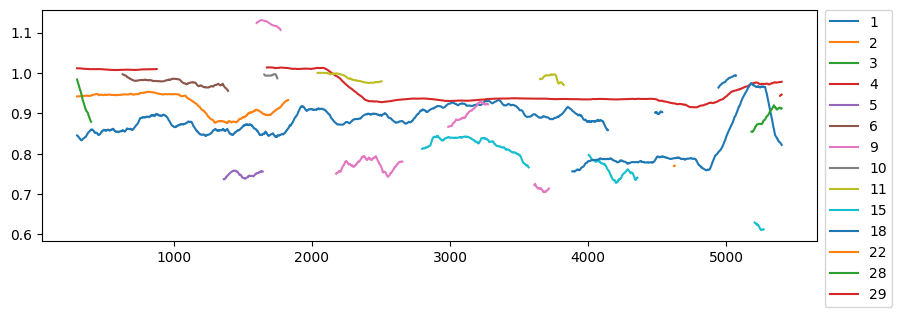

02


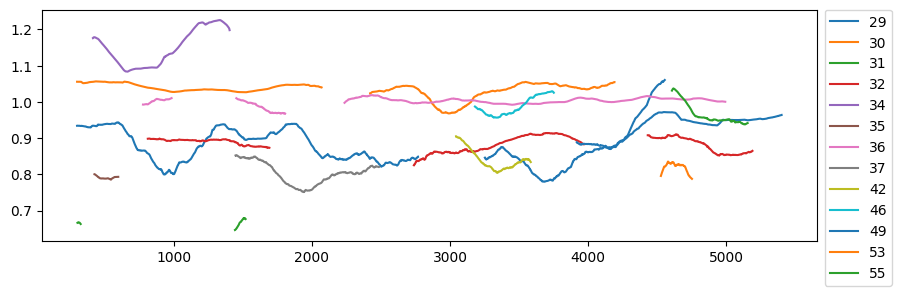

03


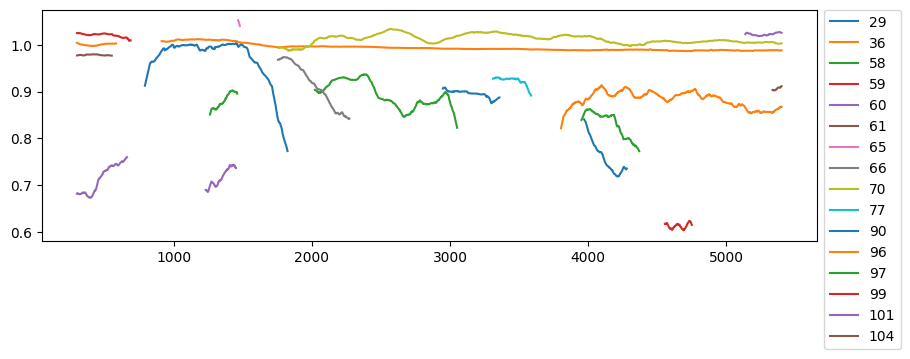

04


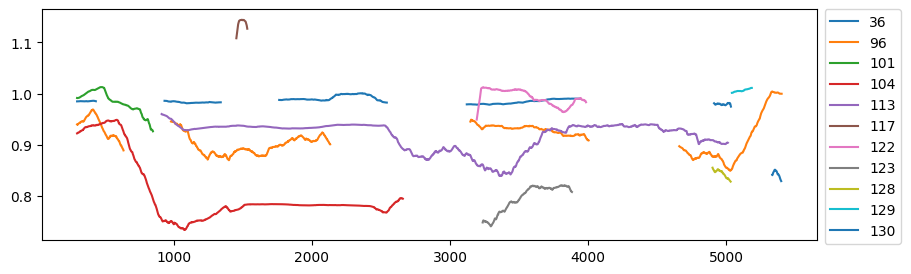

05


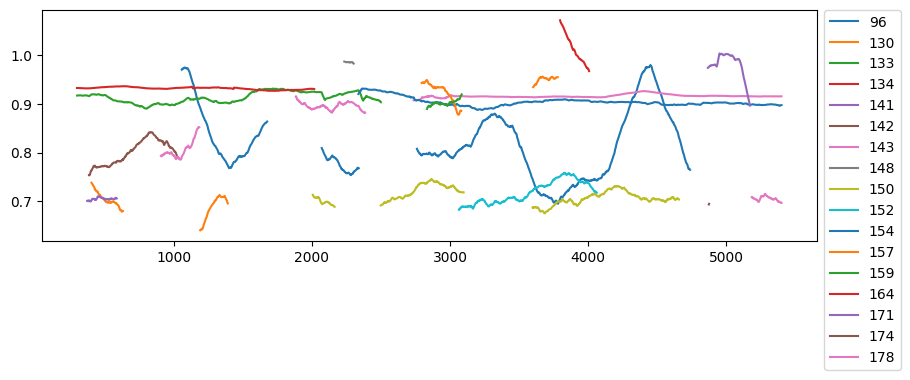

06


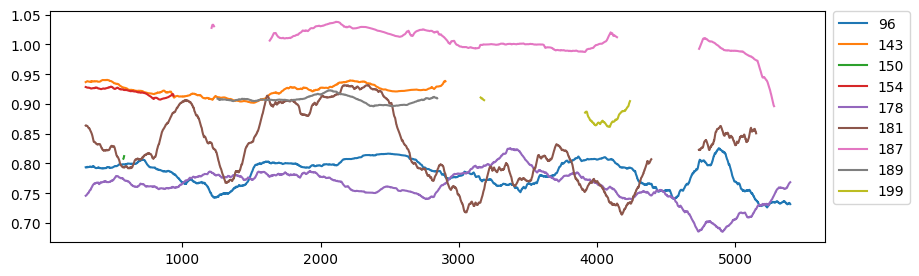

07


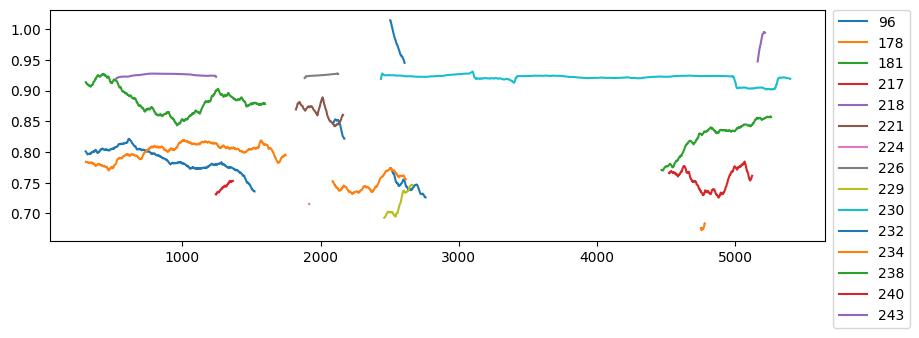

08


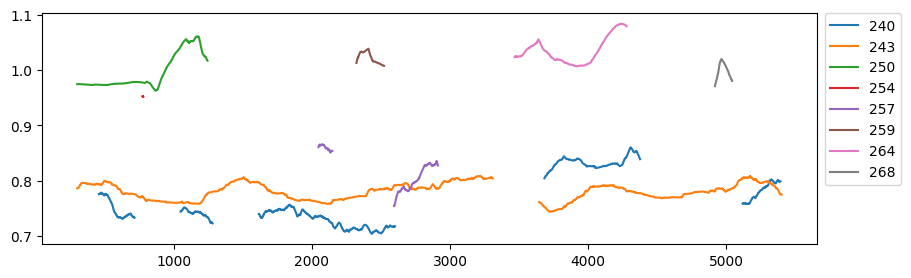

09


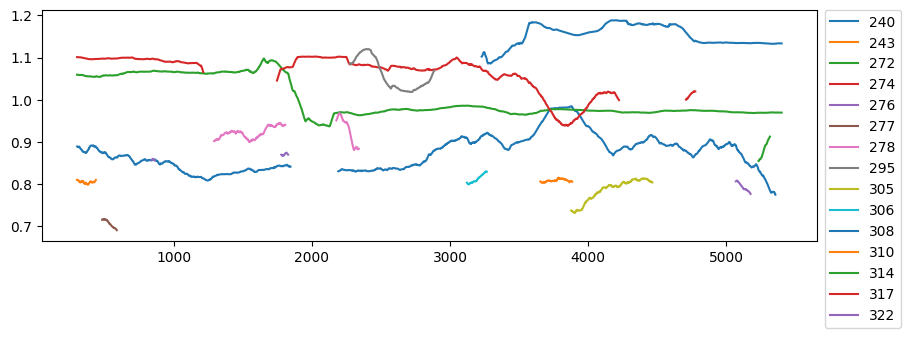

10


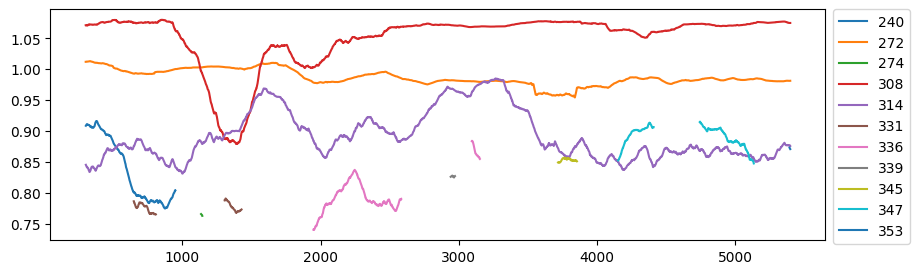

11


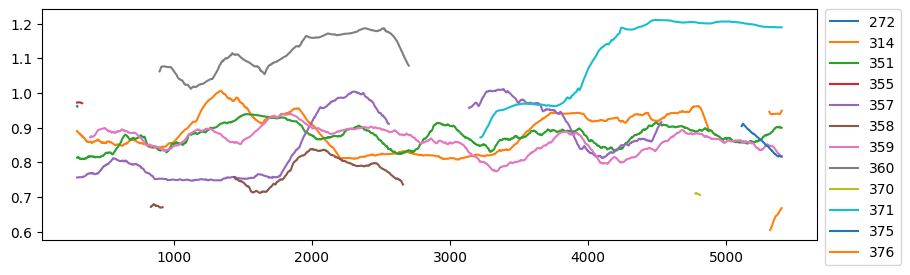

12


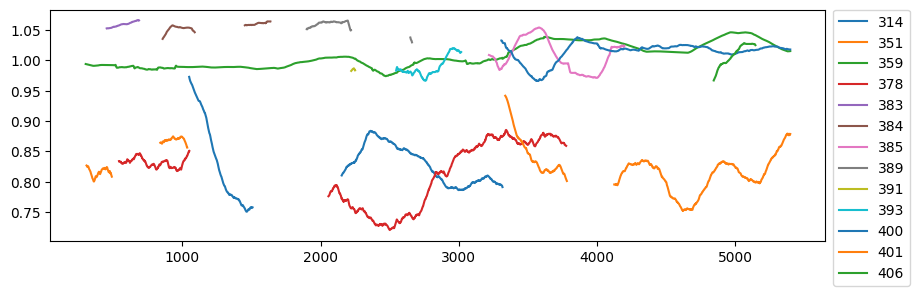

13


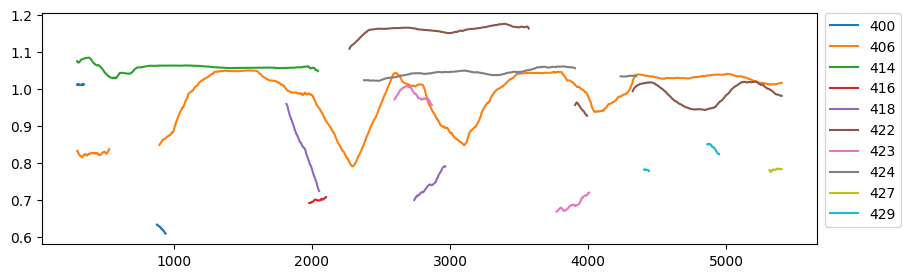

14


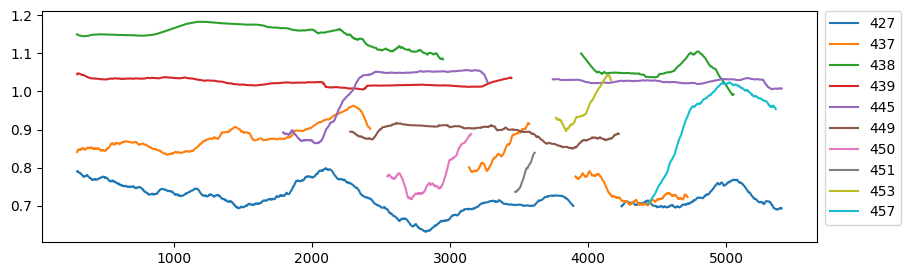

15


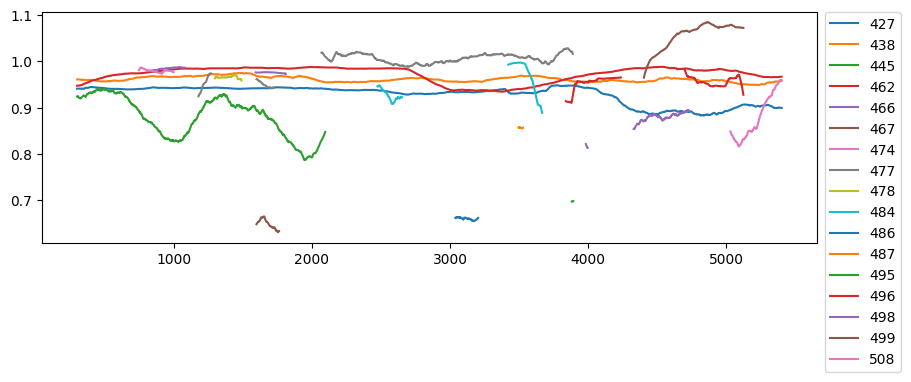

16


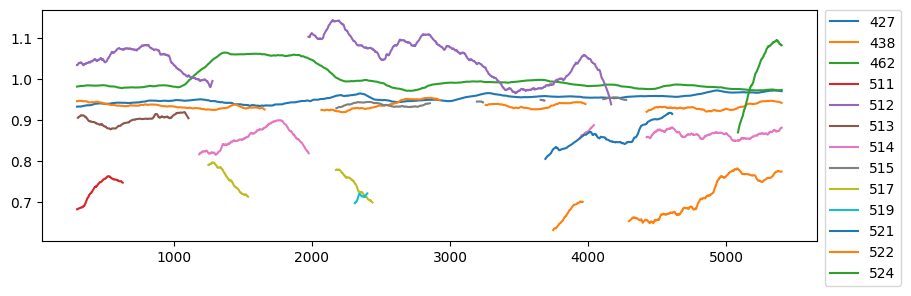

17


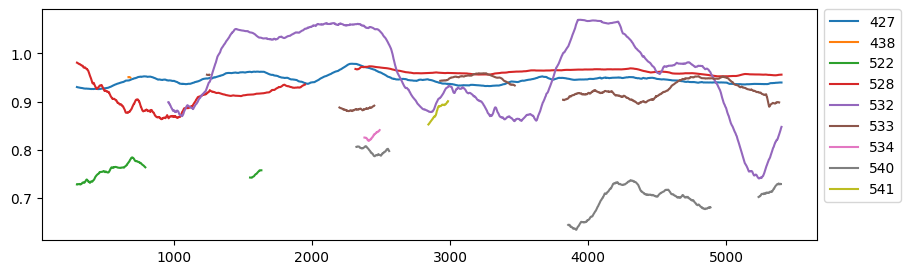

18


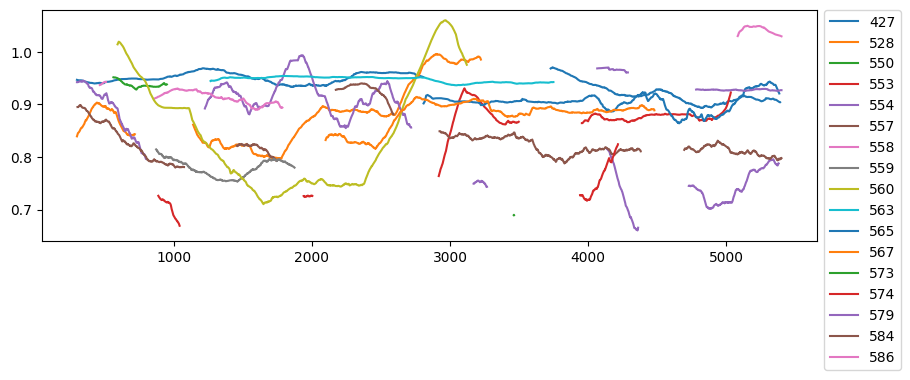

19


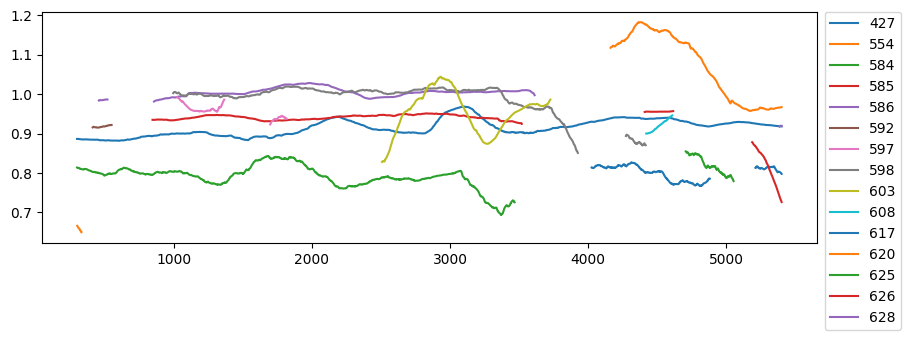

20


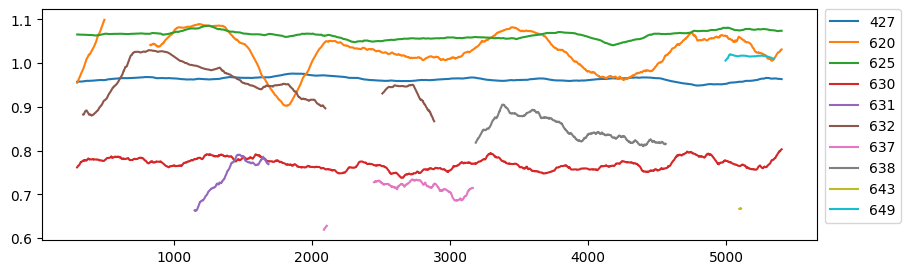

In [30]:
lmd = 0.0
train_results_ind = get_results_ind(train_results)
plot(train_results_ind, max_frame_num, lmd, "train")

  0%|          | 0/20 [00:00<?, ?it/s]

01


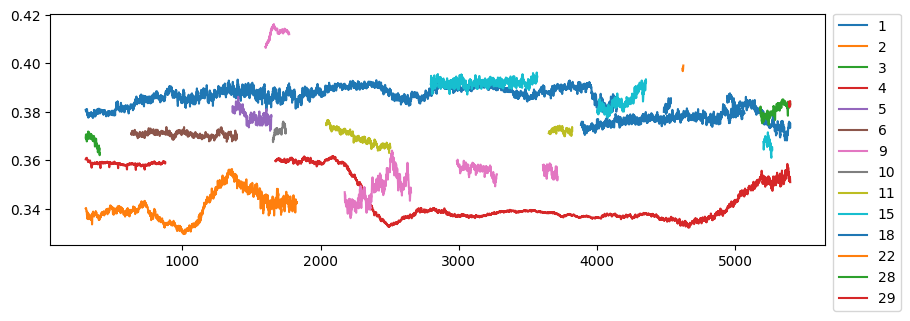

02


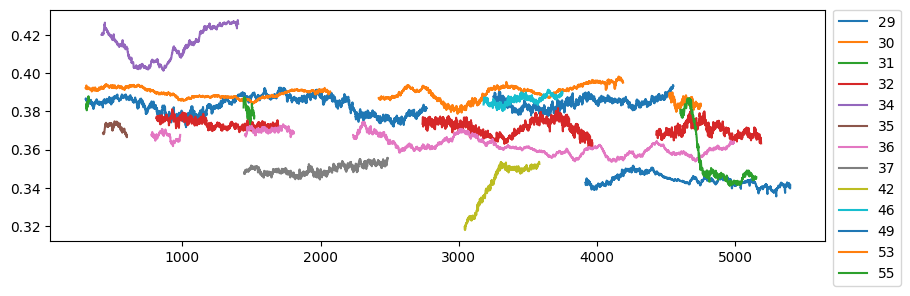

03


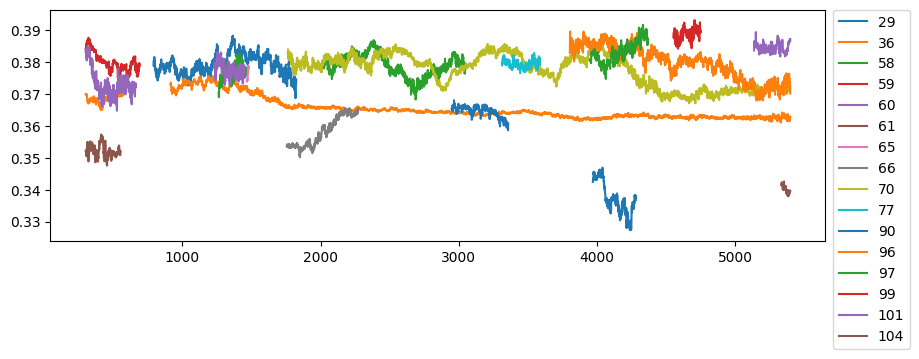

04


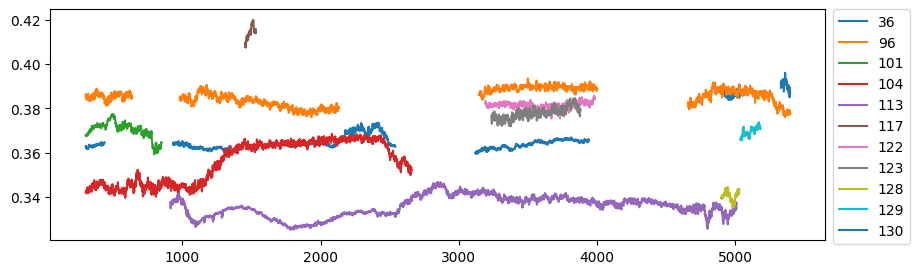

05


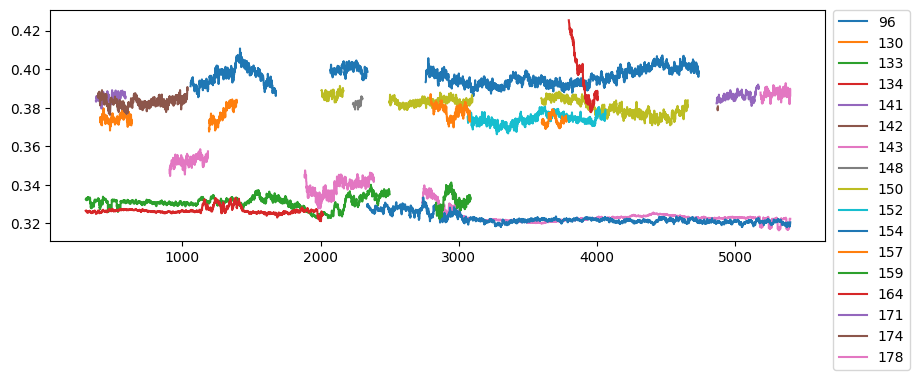

06


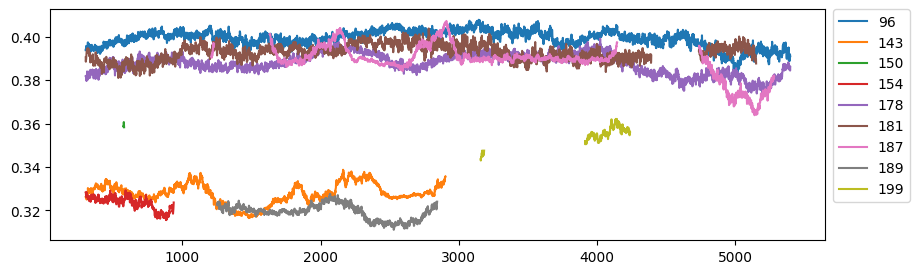

07


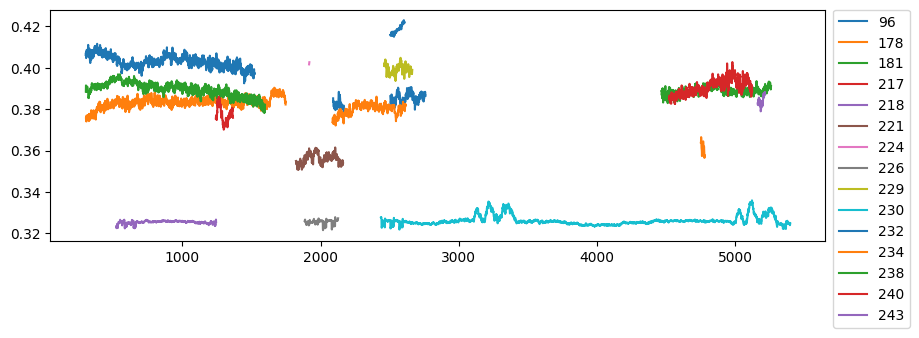

08


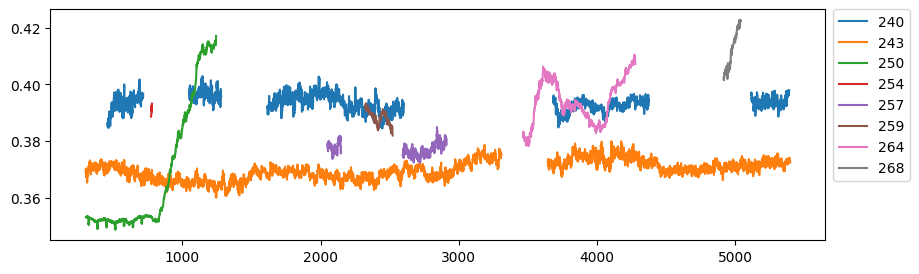

09


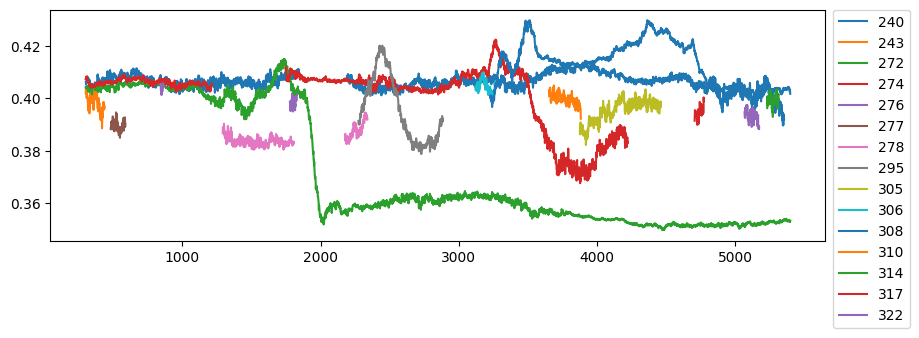

10


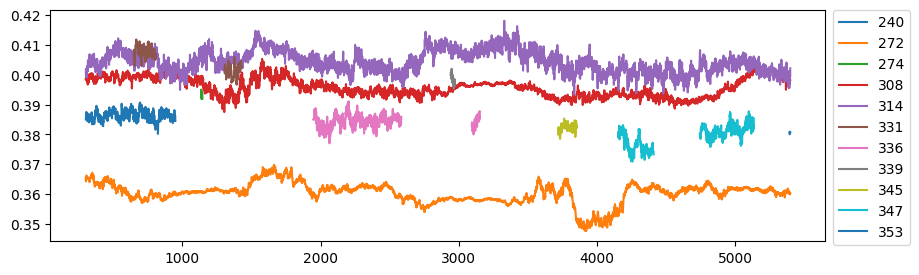

11


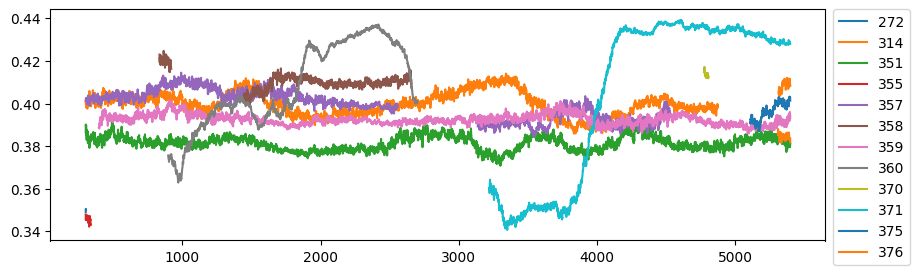

12


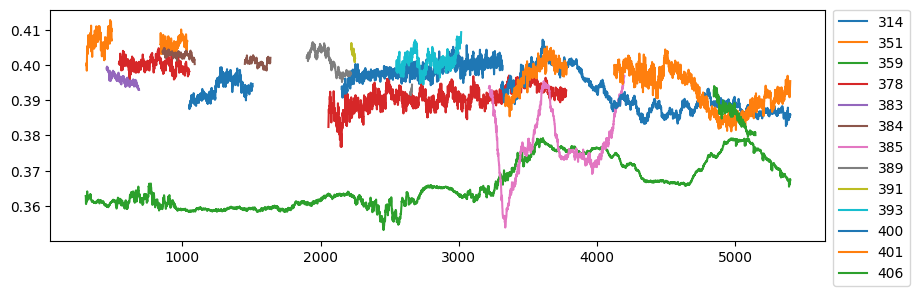

13


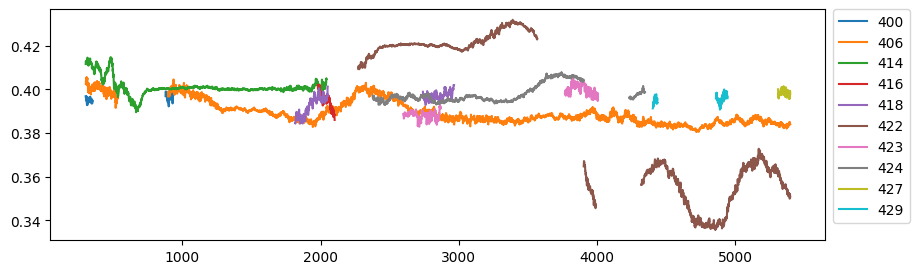

14


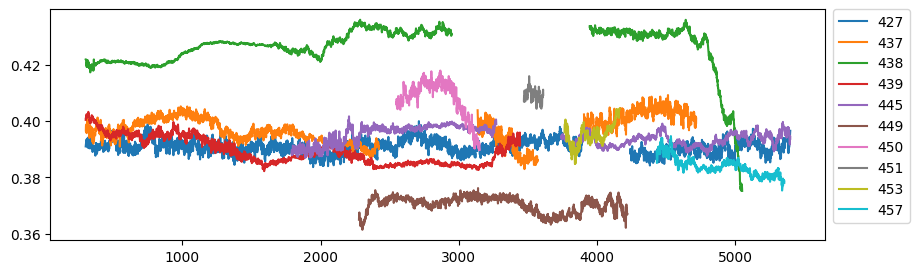

15


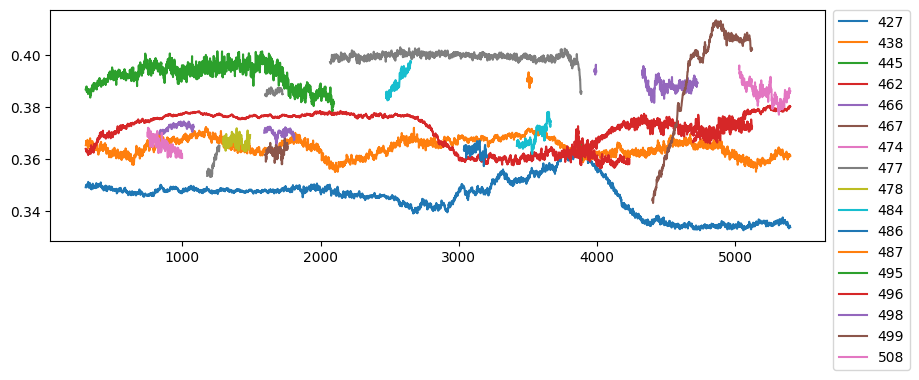

16


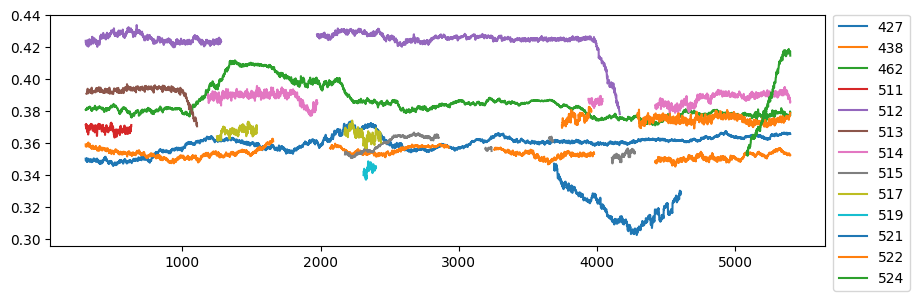

17


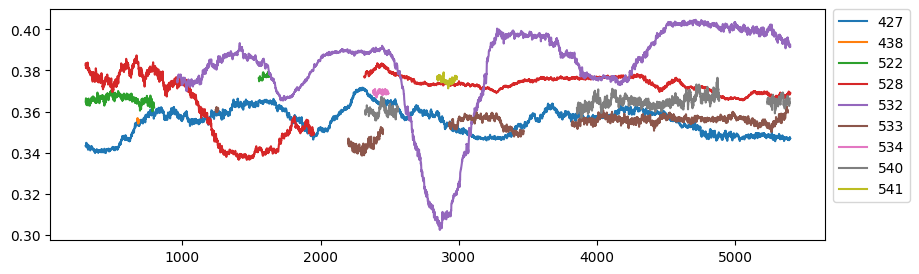

18


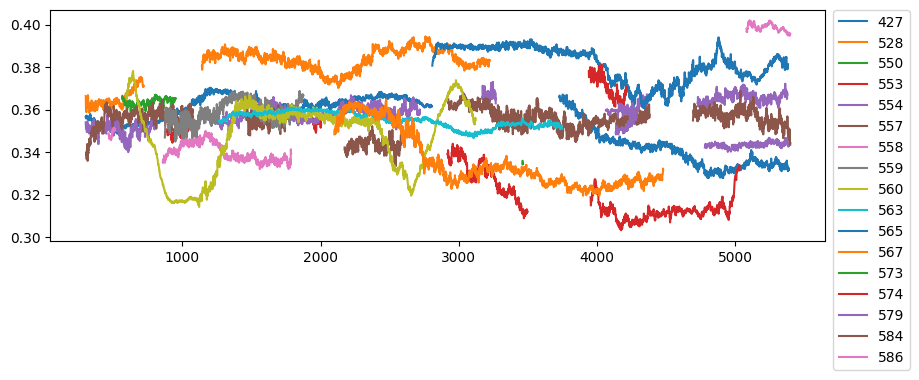

19


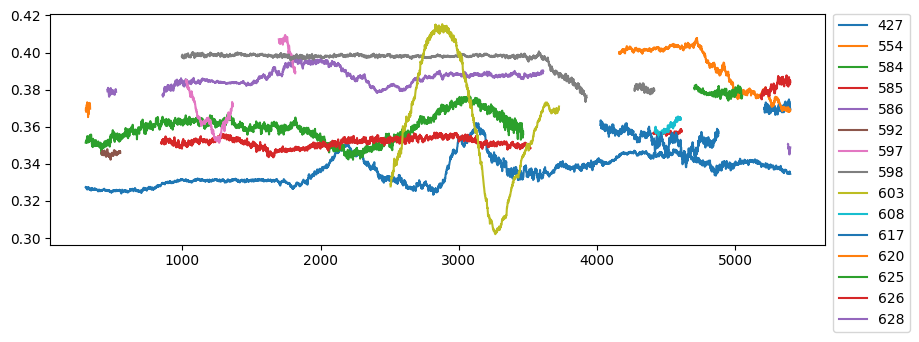

20


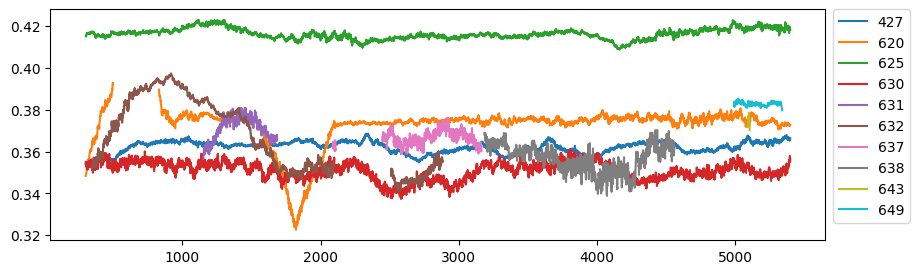

In [31]:
lmd = 1.0
train_results_ind = get_results_ind(train_results)
plot(train_results_ind, max_frame_num, lmd, "train")

# Test Data

  0%|          | 0/20 [00:00<?, ?it/s]

01


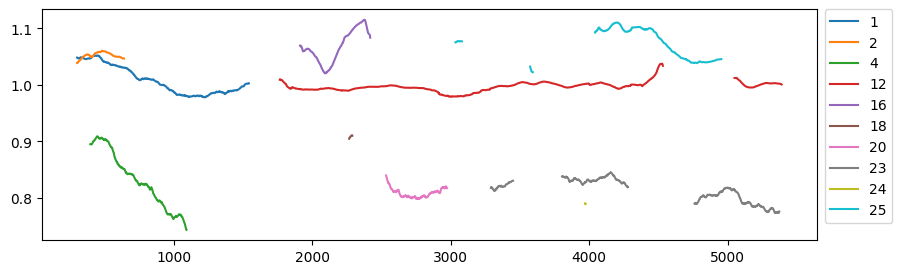

02


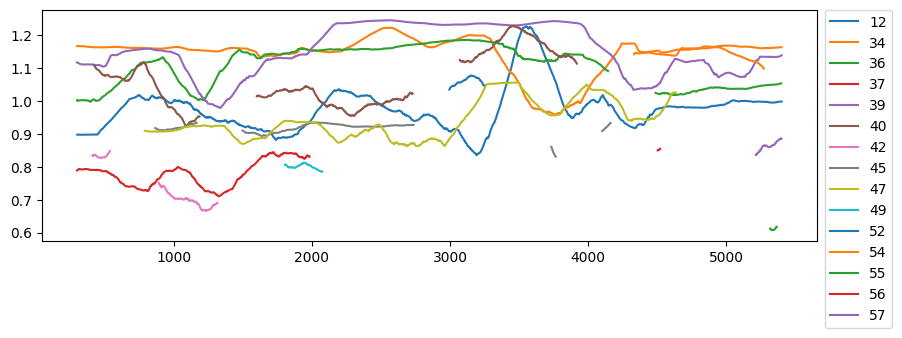

03


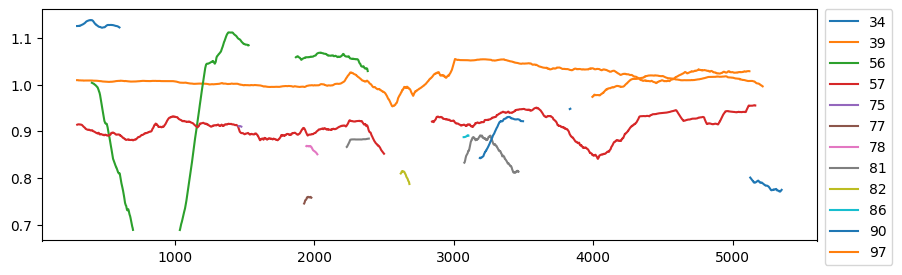

04


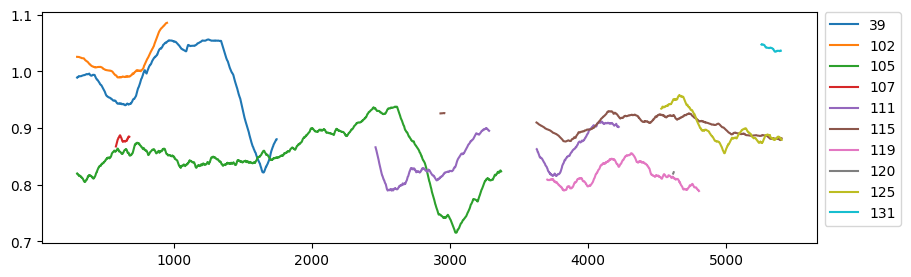

05


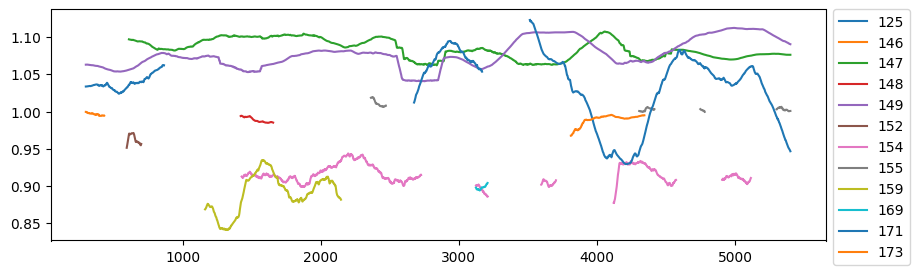

06


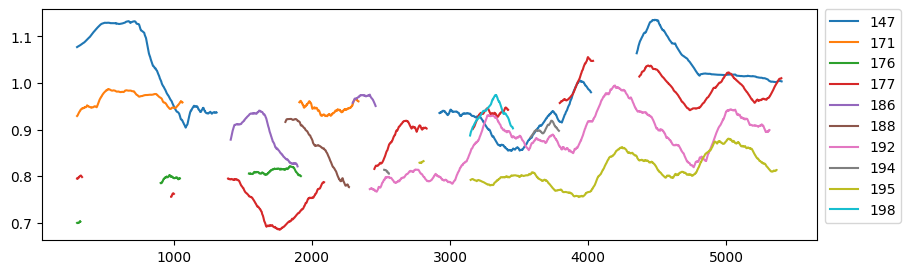

07


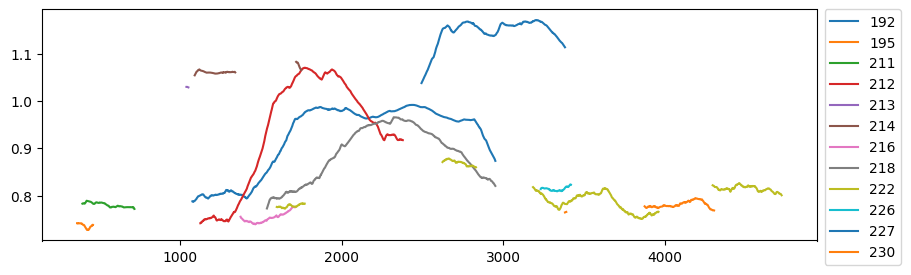

08


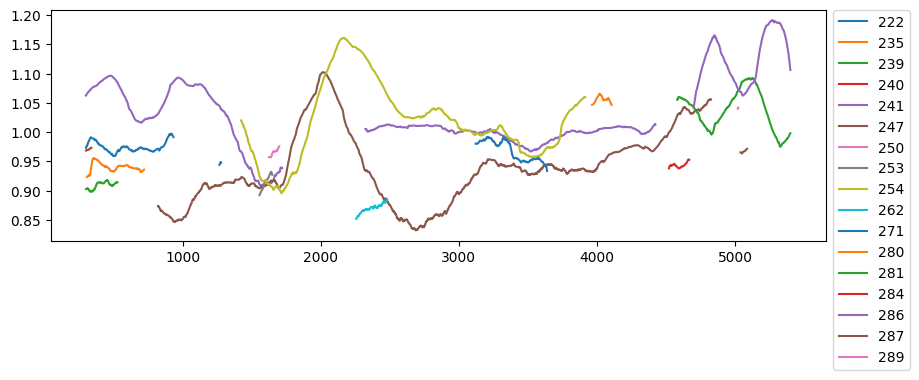

09


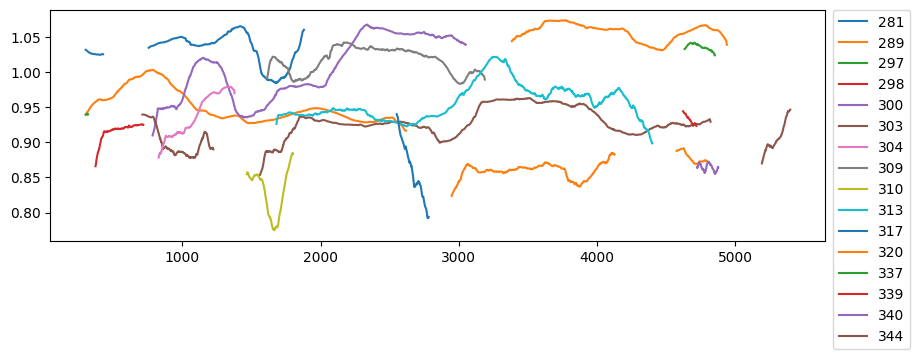

10


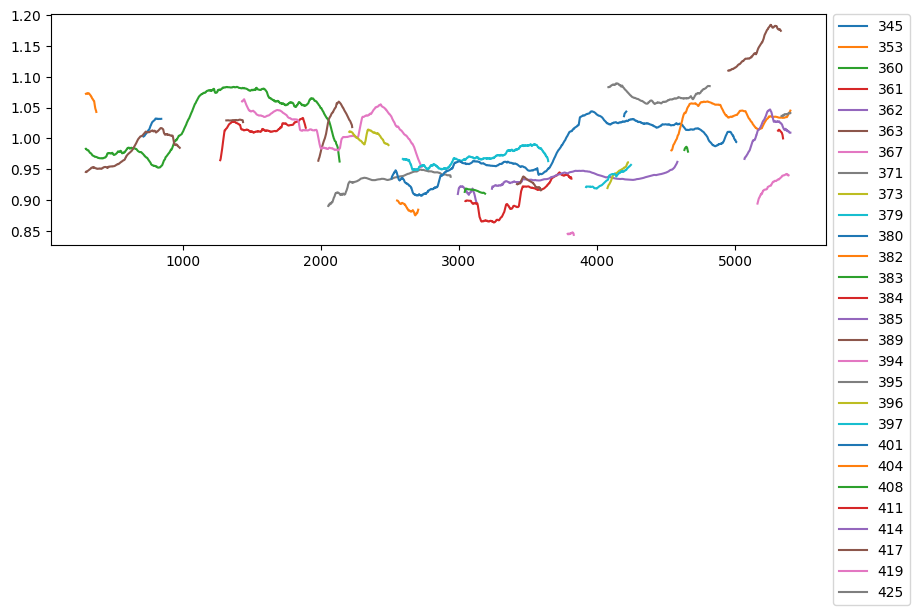

11


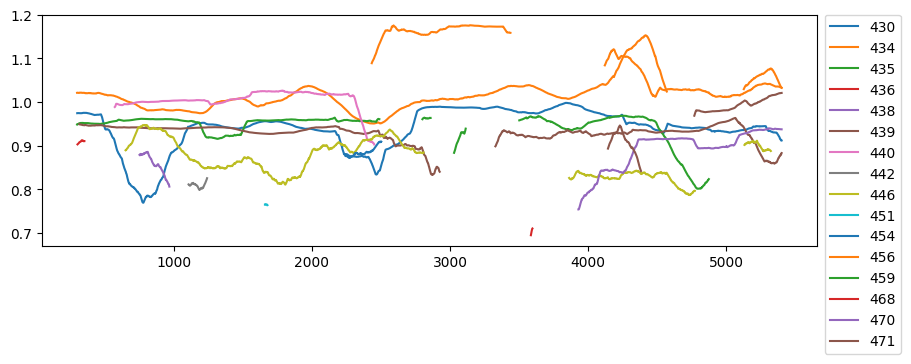

12


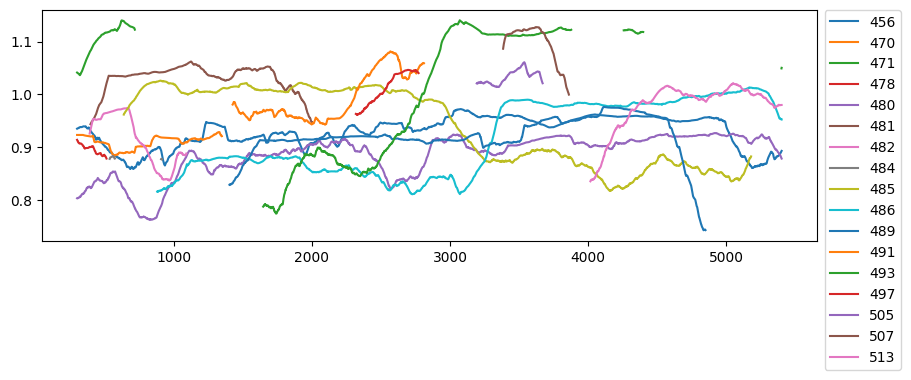

13


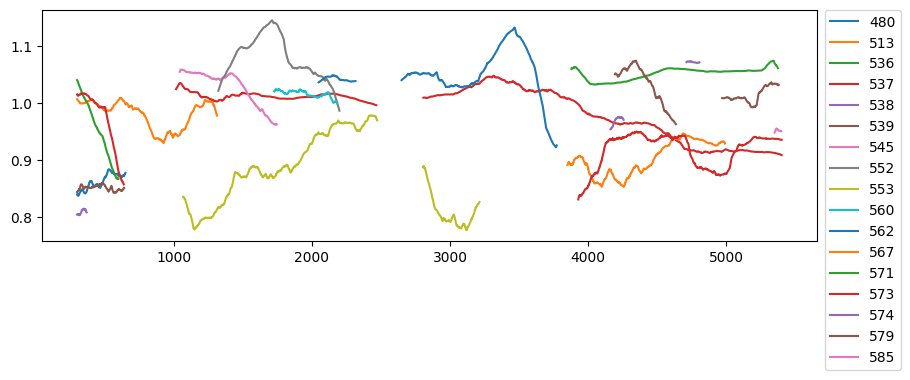

14


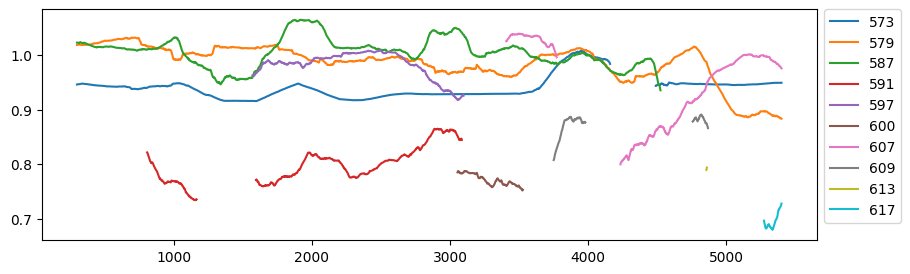

15


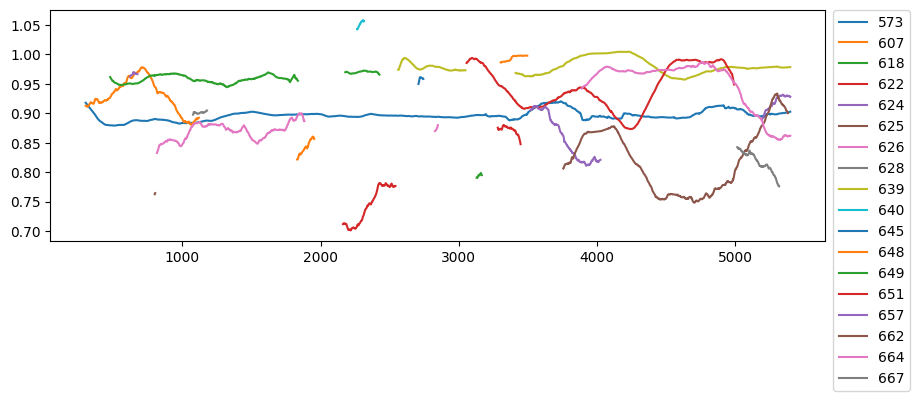

16


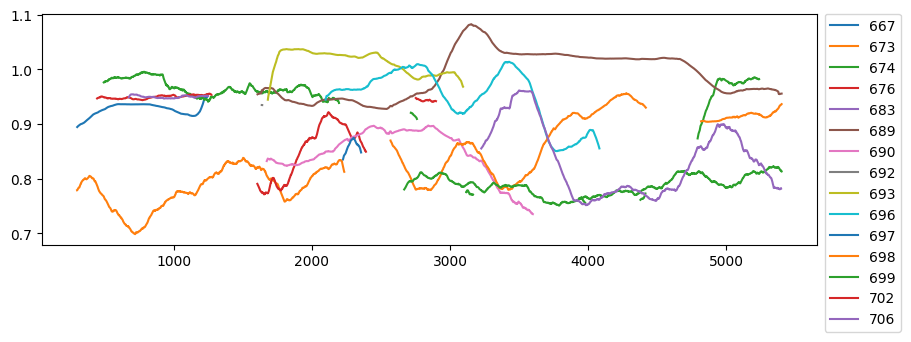

17


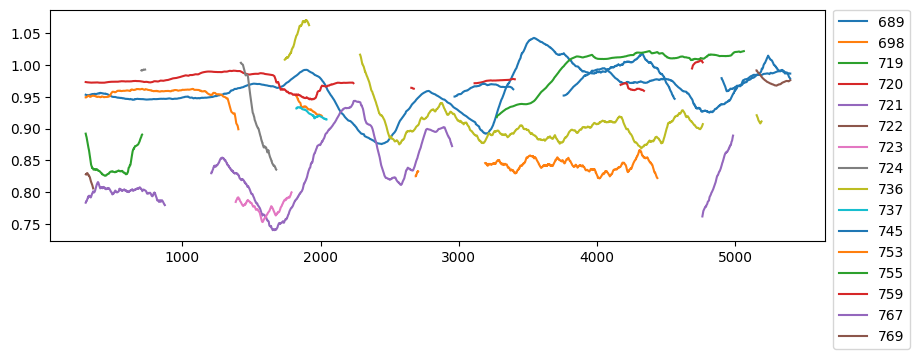

18


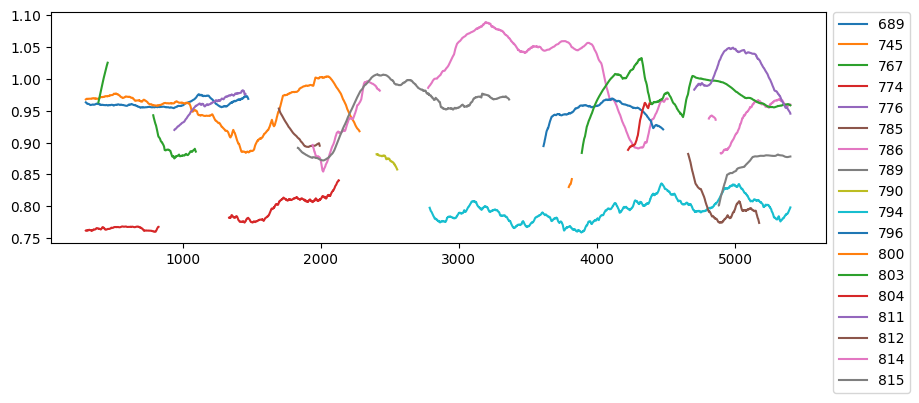

19


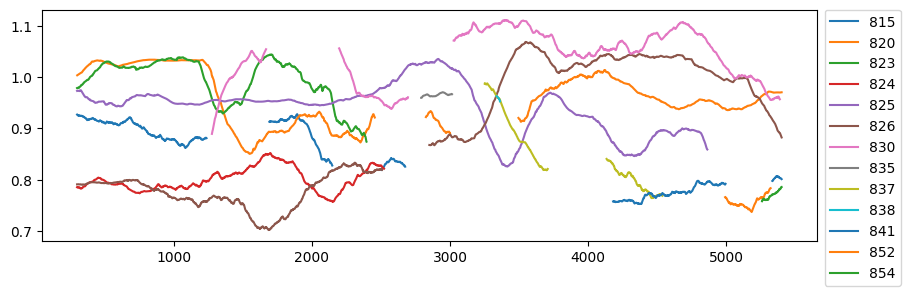

20


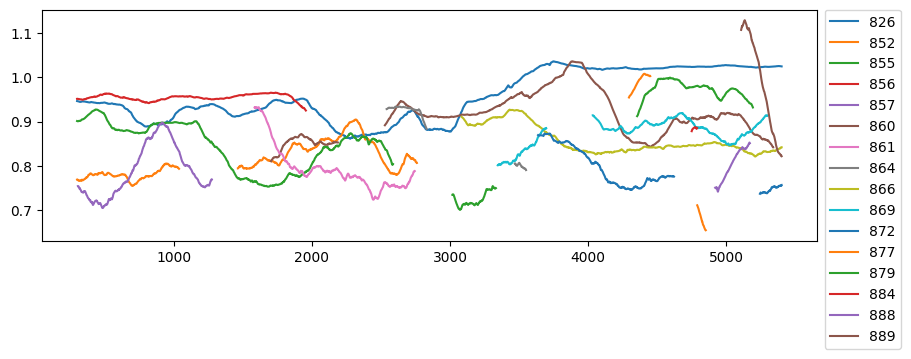

In [32]:
lmd = 0.0
test_results_ind = get_results_ind(test_results)
plot(test_results_ind, max_frame_num, lmd, "test")

  0%|          | 0/20 [00:00<?, ?it/s]

01


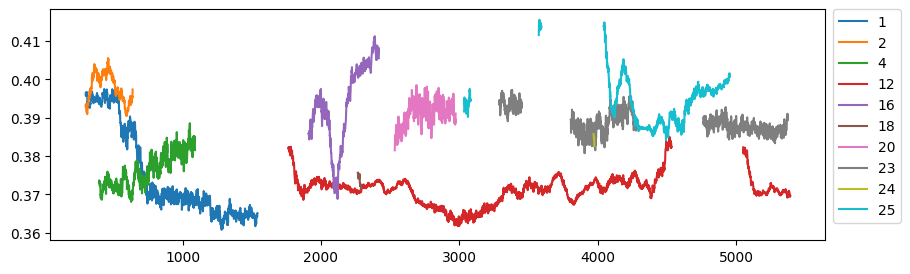

02


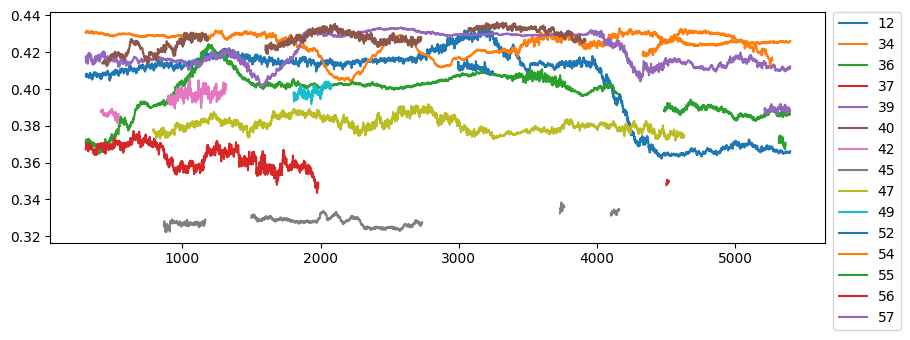

03


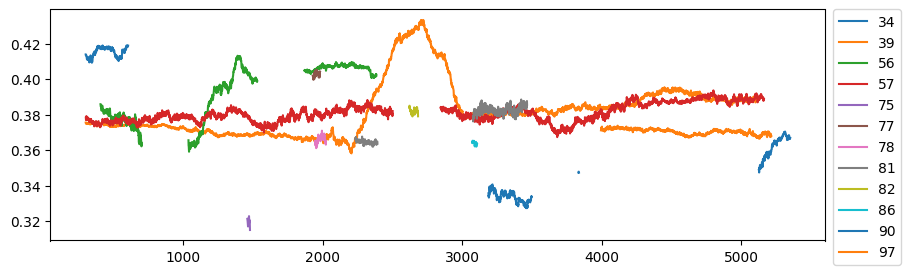

04


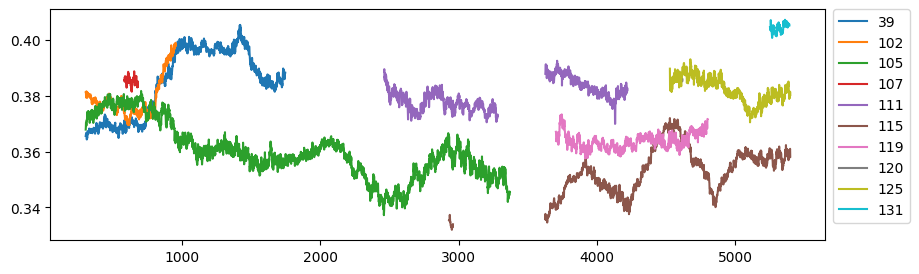

05


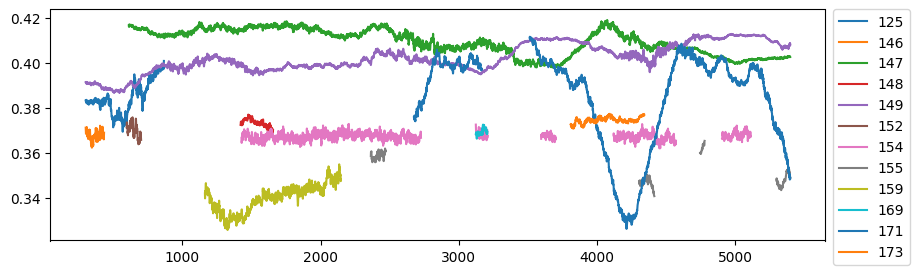

06


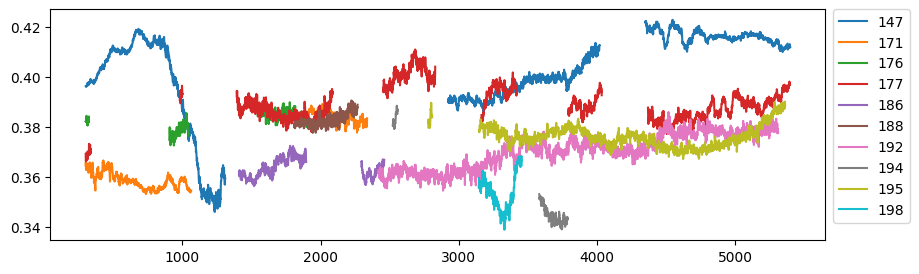

07


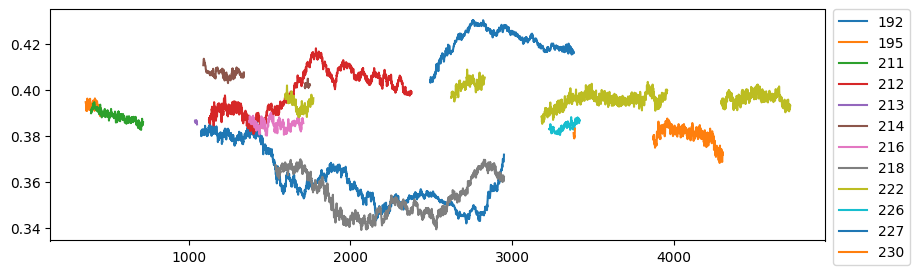

08


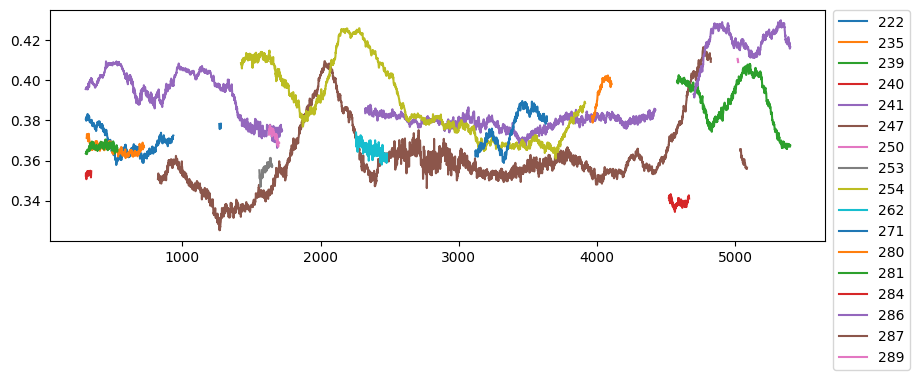

09


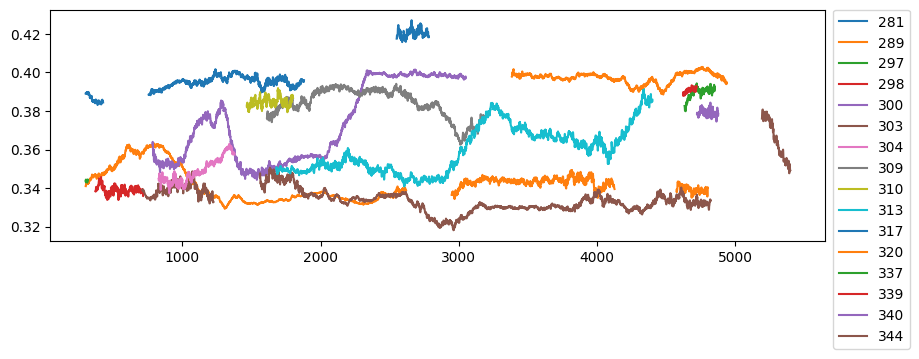

10


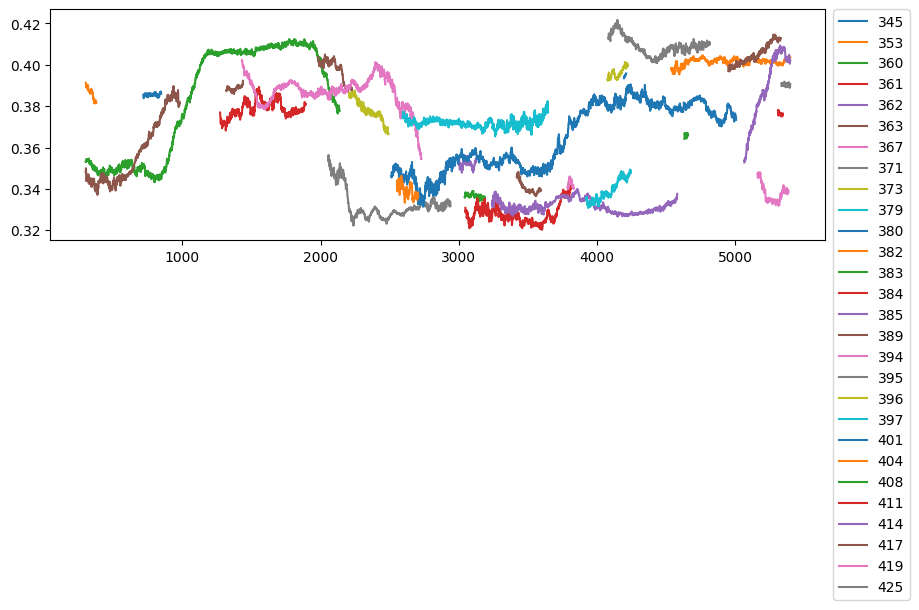

11


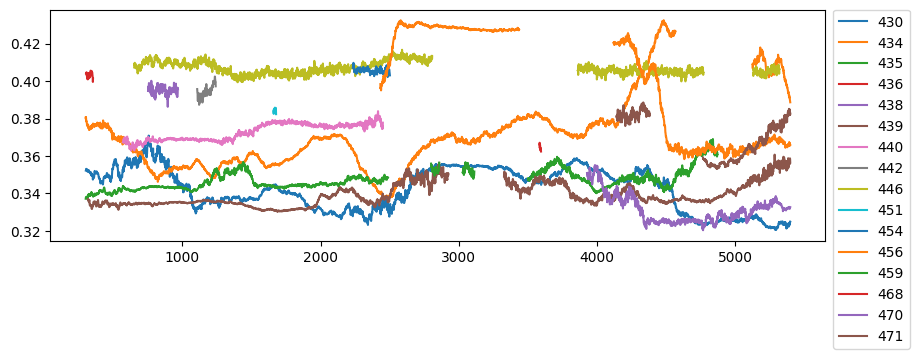

12


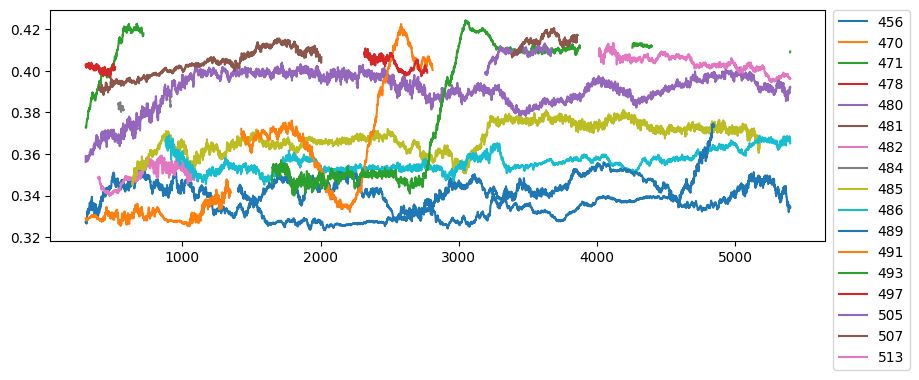

13


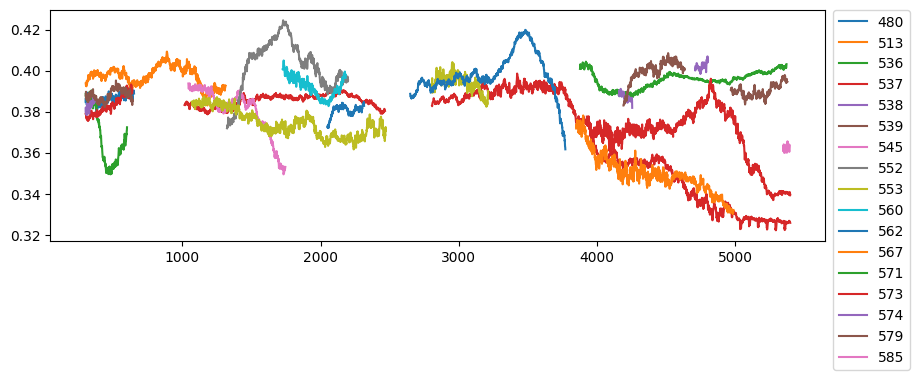

14


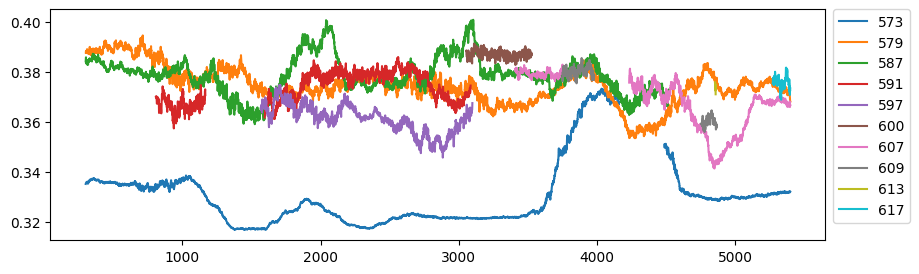

15


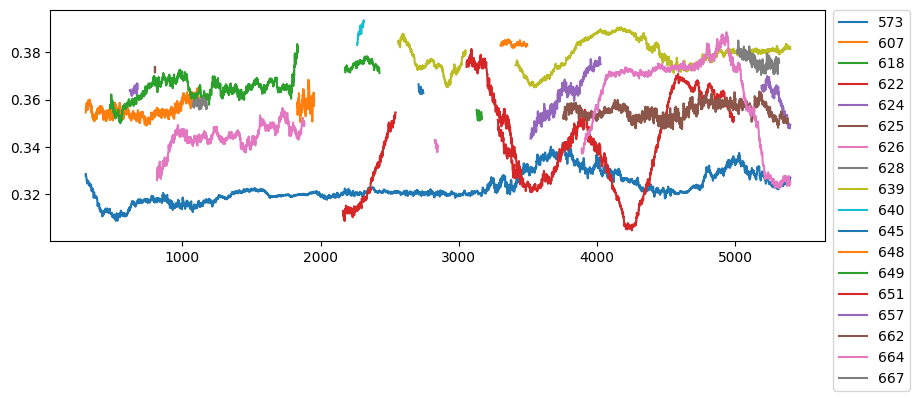

16


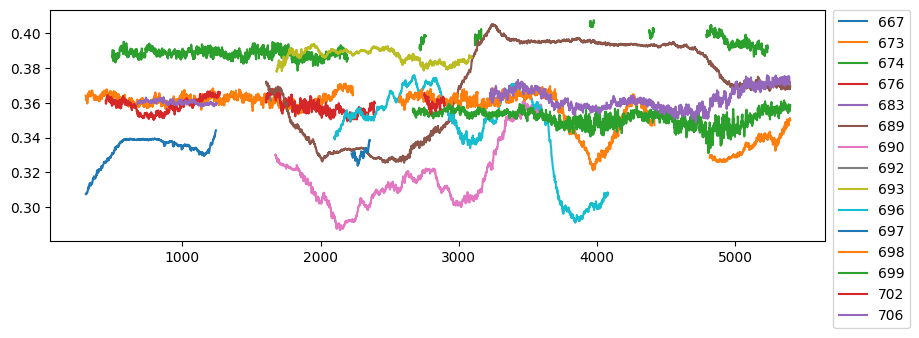

17


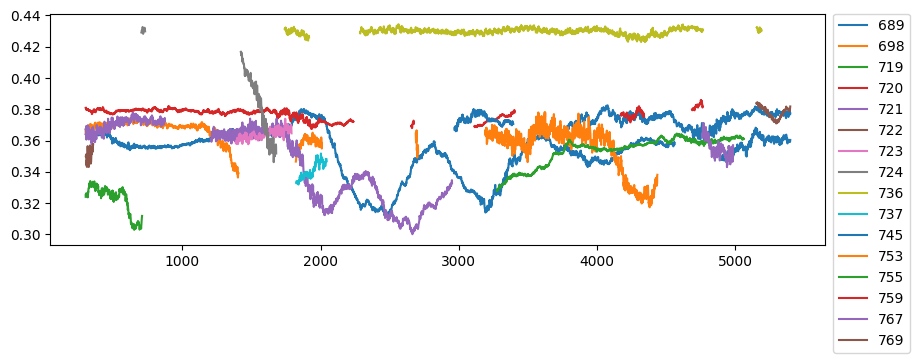

18


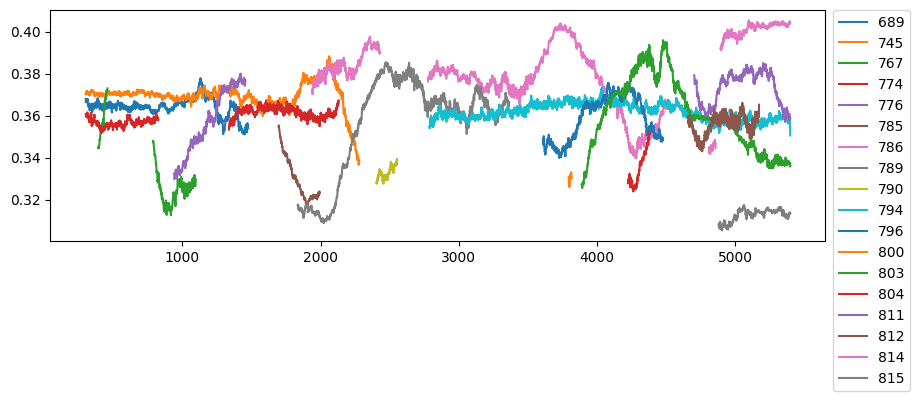

19


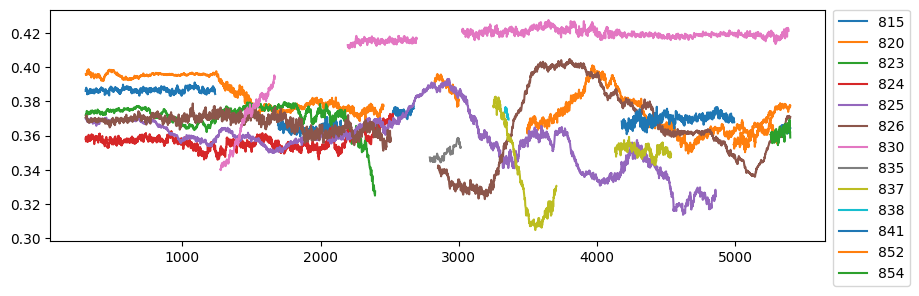

20


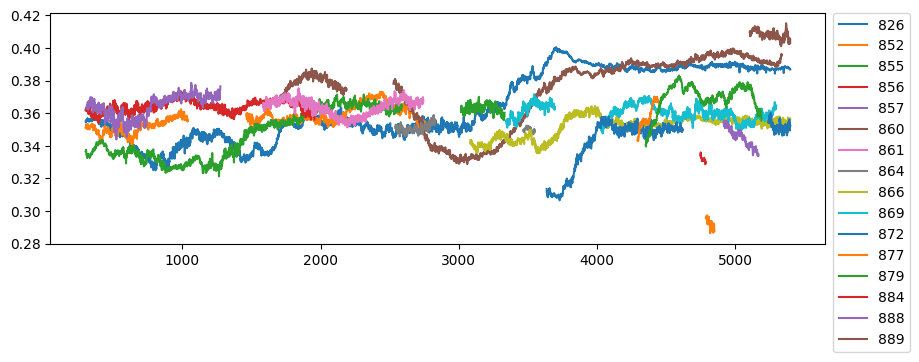

In [33]:
lmd = 1.0
test_results_ind = get_results_ind(test_results)
plot(test_results_ind, max_frame_num, lmd, "test")